In [1]:
# imports:
import numpy as np
import math, os, pickle
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt

import statistics

In [51]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
def netPlot(instance, error):
    instance = list(range(0, instance))
    
    
    with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
        fig, ax = plt.subplots()
        ax.plot(instance, error)

        ax.set(xlabel='instance numebr (s)', ylabel='error (net)',
               title='Average Net Error for each batch run')
        ax.grid()

    plt.show()
    
def sigmoid(x):  
    return 1/(1+np.exp(-x))

def sigmoid_der(x):  
    return sigmoid(x) *(1-sigmoid (x))

def softmax(A):  
    expA = np.exp(A)
    return expA / expA.sum()

def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)
    
def save_it_all(obj, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def saveNet(wh, bh, wo, bo, fileName):
    weights = {"wh":wh, "bh":bh, "wo":wo, "bo":bo}
    save_it_all(weights, fileName)
    
def getArrayFromFile(name):
    array = genfromtxt(name, delimiter=',')
    return array

def mapTargetsToEncoded(targets, tMap):
    newTargets = []
    for item in targets.tolist():
        newTargets.append(tMap[int(item[0])])
    return newTargets

In [117]:
def nn(inputInstance, targetInstance, weightHidden, biasHidden, weightOutput, biasOutput, ohe):
        # feed forward
        # Phase 1 inputs fed through to hidden
        zetaHidden = np.dot(inputInstance, weightHidden) + biasHidden
        activationHidden = sigmoid(zetaHidden)
        
        # Phase 2 hidden fed through to the output
        zetaOutput = np.dot(activationHidden, weightOutput) + biasOutput
        if ohe == 1 :
            activationOutput = softmax(zetaOutput)
        else:
            activationOutput = sigmoid(zetaOutput)
        #### backpropigate with the cross entropy cost function 
        # phase one 
        derivativecost_zetaOutput = activationOutput - targetInstance


        derivativeZetaOutput_derivatieWeightOutput = activationHidden


        derivativecost_weightOutput = np.dot(derivativeZetaOutput_derivatieWeightOutput.T, derivativecost_zetaOutput)


        derivativecost_biasOutput = derivativecost_zetaOutput

        #     # phase two
        derivativeZetaOutput_derivativeActivationHidden = weightOutput

        derivativeCost_derivativeActivationHidden = np.dot(derivativecost_zetaOutput , derivativeZetaOutput_derivativeActivationHidden.T)

        derivativeActivationHidden_derivativeZetaHidden = sigmoid_der(zetaHidden)

        derivativeZetaHidden_derivativeWeightHidden = inputInstance

        derivativeCost_weightHidden = np.dot(derivativeZetaHidden_derivativeWeightHidden.T, derivativeActivationHidden_derivativeZetaHidden * derivativeCost_derivativeActivationHidden)

        derivativeCost_biasHidden = derivativeCost_derivativeActivationHidden * derivativeActivationHidden_derivativeZetaHidden


        #     # Update Weights 

        weightHidden -= learningRate * derivativeCost_weightHidden

        biasHidden -= learningRate * derivativeCost_biasHidden.sum(axis=0)

        weightOutput -= learningRate * derivativecost_weightOutput

        biasOutput -= learningRate * derivativecost_biasOutput.sum(axis=0)
        
        loss = np.sum(-targetInstance * np.log(activationOutput))
        
        return (loss, weightHidden, biasHidden, weightOutput, biasOutput)

In [137]:
# load in fishing normalized set 
#data = getArrayFromFile("normalizeFish.csv")
data = getArrayFromFile("normDigit.csv")
inputs = data[:,0:data.shape[1]-1] # get the input values
targets = data[:, data.shape[1]-1:data.shape[1]] # get the class values
ohe = 0

if np.unique(targets).shape[0] > 2:
    targetMap = load_objects("./TestingdigitTargetCleanDict.pkl")
    oneHotTargets = np.asarray(mapTargetsToEncoded(targets, targetMap), dtype=np.float32)
    ohe = 1

In [138]:
instances = inputs.shape[0]
attributes = inputs.shape[1]

numInputNodes = attributes
numOutputNodes = 1 if np.unique(targets).shape[0] == 2 else np.unique(targets).shape[0]
numHiddenNodes = int((2/3)*(numInputNodes+numOutputNodes))

print("Input node num: "+ str(numInputNodes))
print("Hidden node num: "+ str(numHiddenNodes))
print("Output node num: " + str(numOutputNodes))

lowRange = (-1/math.sqrt(numInputNodes))
highRange = math.fabs(lowRange)

weightHidden = np.random.uniform(low=lowRange, high=highRange, size=(numInputNodes, numHiddenNodes, ))
biasHidden = np.random.uniform(low=lowRange, high=highRange, size=(numHiddenNodes))

weightOutput = np.random.uniform(low=lowRange, high=highRange, size=(numHiddenNodes, numOutputNodes))
biasOutput = np.random.uniform(low=lowRange, high=highRange, size=(numOutputNodes))

print()
print(str(weightHidden.shape))
print(str(biasHidden.shape))
print(str(weightOutput.shape))
print(str(biasOutput.shape))

print()
print(str(inputs.shape))
print()
learningRate = .1

errorCost = []
batchError = []

for epoch in range(55):
    trackedNetError= []
    print("------------Epoch: "+str(epoch)+"--")
    for instanceRow in range(0, instances):
        
        inputInstance = np.array([inputs[instanceRow]])
        if ohe == 1:
            targetInstance = np.array([oneHotTargets[instanceRow]])
        else:
            targetInstance = targets[instanceRow]
        
        loss, weightHidden, biasHidden, weightOutput, biasOutput = nn(inputInstance, targetInstance, weightHidden, biasHidden, weightOutput, biasOutput, ohe)

        trackedNetError.append(loss)
    avg_err = statistics.mean(trackedNetError)
    print("Loss: "+str(avg_err))
    batchError.append(avg_err)
    print()


Input node num: 64
Hidden node num: 49
Output node num: 10

(64, 49)
(49,)
(49, 10)
(10,)

(3823, 64)

------------Epoch: 0--
Loss: 0.6314253708100744

------------Epoch: 1--
Loss: 0.1456533641705107

------------Epoch: 2--
Loss: 0.11110064358885757

------------Epoch: 3--
Loss: 0.09102924933180853

------------Epoch: 4--
Loss: 0.07731825896160296

------------Epoch: 5--
Loss: 0.06741017471594887

------------Epoch: 6--
Loss: 0.059717424897001326

------------Epoch: 7--
Loss: 0.05323625892754378

------------Epoch: 8--
Loss: 0.047402574840986984

------------Epoch: 9--
Loss: 0.04199101734390752

------------Epoch: 10--
Loss: 0.03695527493735516

------------Epoch: 11--
Loss: 0.03233056145415097

------------Epoch: 12--
Loss: 0.02820457281724835

------------Epoch: 13--
Loss: 0.024624508273553794

------------Epoch: 14--
Loss: 0.021561307360779387

------------Epoch: 15--
Loss: 0.018954279565495176

------------Epoch: 16--
Loss: 0.016741222975233526

------------Epoch: 17--
Loss: 0.0148

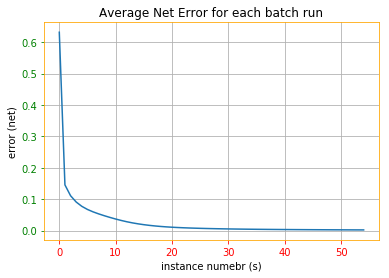

In [139]:
netPlot(55, batchError)

In [140]:
saveNet(weightHidden, biasHidden, weightOutput, biasOutput, "./digitNet.pkl")

In [123]:
saveNet(weightHidden, biasHidden, weightOutput, biasOutput, "./fishNet.pkl")

# Classify digits

In [141]:
data = getArrayFromFile("testDigit.csv")
#data = np.array([getArrayFromFile("normalizeFishTest.csv")])
inputs = data[:,0:data.shape[1]-1] # get the input values
targets = data[:, data.shape[1]-1:data.shape[1]] # get the class values

ohe = 0

if np.unique(targets).shape[0] > 2:
    ohe = 1
    
instances = inputs.shape[0]
attributes = inputs.shape[1]

numInputNodes = attributes
numOutputNodes = 1 if np.unique(targets).shape[0] == 2 else np.unique(targets).shape[0]
numHiddenNodes = int((2/3)*(numInputNodes+numOutputNodes))

nnw = load_objects("./digitNet.pkl")
#nnw = load_objects("./fishNet.pkl")

wh = nnw["wh"]
bh = nnw["bh"]
wo = nnw["wo"]
bo = nnw["bo"]

correct = 0
for instanceRow in range(0, instances):
    
    inputInstance = np.array([inputs[instanceRow]])
    target = int(targets[instanceRow][0])
    
    zetaHidden = np.dot(inputInstance, weightHidden) + biasHidden
    activationHidden = sigmoid(zetaHidden)

    # Phase 2 hidden fed through to the output
    zetaOutput = np.dot(activationHidden, weightOutput) + biasOutput
    if ohe == 1:
        activationOutput = softmax(zetaOutput)
    else:
        activationOutput = sigmoid(zetaOutput)
        
    pred = np.where(activationOutput==np.max(activationOutput))[1][0] if ohe == 1 else int(round(activationOutput[0][0]))
    
    if(pred == target):
        correct = correct + 1
        
totalPercentRight = (correct/instances)*100

In [142]:
totalPercentRight

96.661101836394

In [127]:
data.shape

(1, 8)

In [128]:
inputs

array([[0., 0., 0., 1., 0., 1., 0.]])

In [132]:
activationOutput

array([[0.85729332]])